# RNN BUILD

* Først hente og rense data ved bruk av eget lib
* Så sette opp en modell
* Trene og validere -> Deretter teste på ny data
* Lagre modellen

Ops ops: Modellen kan kun bukes på data med 3 dimensjoner. Det betyr at det alltid på komme i en sekvens på minimum (2, 30, 5)

In [1]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from lib.rens import rens
from lib.create_dataset import create_dataset
from lib.make_ready import make_ready


In [2]:
# Pickle save and load premake file.
#import pickle
#with open('premade_data/79dager.pkl', 'wb') as f:
#    pickle.dump(data, f)
    
# Load
with open('premade_data/79dager.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
def r2_score_nn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def add_data(word):
    ordet = 'data/' + word
    return ordet

In [8]:
filer = list(map(add_data, os.listdir('data/')))[0:1] # test 54:60 mellom 10 og 14 er noe feil
data = make_ready().use_stockstats(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [9]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,239.0,239.0,239.0,239.0,5179,5179,0.5,0.5,0.500000,...,239.000000,0.000000,0.000000,0.000000,239.000000,239.000000,0.0000,1.000000,1.000000,1.000000
1,9:1,239.2,239.2,239.2,239.2,180,180,239.0,0.2,0.500000,...,239.100000,0.004487,0.002493,0.001994,239.100000,239.100000,0.0000,1.000000,1.000000,1.000000
2,9:2,241.0,241.0,241.0,241.0,2396,2396,239.2,1.8,0.500000,...,239.733333,0.061535,0.026691,0.034845,239.733333,239.733333,0.0000,1.002649,1.002649,1.007525
3,9:3,242.2,242.2,242.2,242.2,3733,3733,241.0,1.2,0.500000,...,240.350000,0.129300,0.061450,0.067850,240.350000,240.350000,0.0000,1.002572,1.002572,1.004979
4,9:4,245.2,245.2,245.2,245.2,2865,2865,242.2,3.0,0.500000,...,241.320000,0.282776,0.127289,0.155487,241.320000,241.320000,0.0000,1.004036,1.004036,1.012386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16:16,240.4,240.4,240.4,240.4,14,14,240.2,0.2,1.137037,...,240.187500,0.254409,0.255595,-0.001187,239.526667,240.200000,0.2125,1.000278,1.000111,1.000833
373,16:17,240.4,240.4,240.4,240.4,2320,2320,240.4,0.0,1.137037,...,240.212500,0.251285,0.254733,-0.003448,239.580000,240.213333,0.1375,1.000223,1.000056,1.000000
374,16:18,240.4,240.4,240.4,240.4,433,433,240.4,0.0,1.137037,...,240.225000,0.245974,0.252981,-0.007008,239.640000,240.266667,0.0750,1.000250,1.000222,1.000000
375,16:19,239.6,239.6,239.6,239.6,5663,5663,240.4,-0.8,0.876858,...,240.225000,0.175192,0.237424,-0.062232,239.726667,240.266667,-0.0250,1.000362,1.000000,0.996672


In [45]:
def prepare_data_for_training(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.extend(datax)
        datayes.extend(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)


def prepare_data_for_test(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.append(datax)
        datayes.append(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)
    
    
dataxes, datayes = prepare_data_for_training(data)


In [46]:
# split in train and val for training
X_train, X_test, y_train, y_test = train_test_split(dataxes, datayes, test_size=0.33, shuffle=True, random_state=42)
X_train.shape

(16807, 30, 5)

## Lage modellen
Bruker LSTM. gode greier. Har ikke gridsearched eller kfold.

In [48]:
model = Sequential()

model.add(LSTM(units=64, input_dim=5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_nn])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 64)          17920     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 51,594
Trainable params: 51,594
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=64, verbose=1)

Train on 16807 samples, validate on 8279 samples
Epoch 1/60
16807/16807 [==============================] - 20s 1ms/sample - loss: 0.1248 - mae: 0.2366 - r2_score_nn: 0.4973 - val_loss: 0.0983 - val_mae: 0.2115 - val_r2_score_nn: 0.6031
Epoch 2/60
16807/16807 [==============================] - 16s 974us/sample - loss: 0.1004 - mae: 0.2135 - r2_score_nn: 0.5884 - val_loss: 0.0890 - val_mae: 0.1998 - val_r2_score_nn: 0.6363
Epoch 3/60
16807/16807 [==============================] - 16s 958us/sample - loss: 0.0916 - mae: 0.2046 - r2_score_nn: 0.6230 - val_loss: 0.0813 - val_mae: 0.1914 - val_r2_score_nn: 0.6678
Epoch 4/60
16807/16807 [==============================] - 17s 987us/sample - loss: 0.0859 - mae: 0.1988 - r2_score_nn: 0.6472 - val_loss: 0.0784 - val_mae: 0.1883 - val_r2_score_nn: 0.6813
Epoch 5/60
16807/16807 [==============================] - 17s 994us/sample - loss: 0.0801 - mae: 0.1935 - r2_score_nn: 0.6661 - val_loss: 0.0729 - val_mae: 0.1830 - val_r2_score_nn: 0.7015
Epoch 6/

16807/16807 [==============================] - 17s 985us/sample - loss: 0.0312 - mae: 0.1274 - r2_score_nn: 0.8684 - val_loss: 0.0304 - val_mae: 0.1252 - val_r2_score_nn: 0.8724
Epoch 45/60
16807/16807 [==============================] - 16s 975us/sample - loss: 0.0320 - mae: 0.1288 - r2_score_nn: 0.8654 - val_loss: 0.0346 - val_mae: 0.1322 - val_r2_score_nn: 0.8568
Epoch 46/60
16807/16807 [==============================] - 16s 972us/sample - loss: 0.0312 - mae: 0.1273 - r2_score_nn: 0.8694 - val_loss: 0.0294 - val_mae: 0.1232 - val_r2_score_nn: 0.8768
Epoch 47/60
16807/16807 [==============================] - 16s 967us/sample - loss: 0.0299 - mae: 0.1250 - r2_score_nn: 0.8744 - val_loss: 0.0297 - val_mae: 0.1236 - val_r2_score_nn: 0.8760
Epoch 48/60
16807/16807 [==============================] - 16s 981us/sample - loss: 0.0298 - mae: 0.1245 - r2_score_nn: 0.8741 - val_loss: 0.0288 - val_mae: 0.1219 - val_r2_score_nn: 0.8796
Epoch 49/60
16807/16807 [==============================] - 17s

### Plotte validation kurve

max val_r2 0.8995835185050964


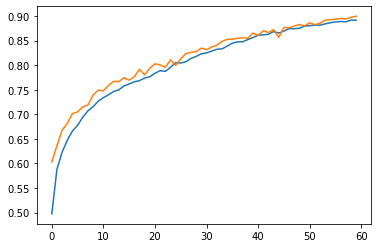

In [50]:
plt.plot(history.history['r2_score_nn'])
plt.plot(history.history['val_r2_score_nn'])
#plt.xlim(50,100)
#plt.ylim(0.0, 0.025)
print(f"max val_r2 {np.max(history.history['val_r2_score_nn'])}")

### Gjennomføre en tes 
Henter helt nye data for å gjennomføre en test på modellen.

In [51]:
filer = list(map(add_data, os.listdir('data/')))[55:60] # test 54:60
data_test = make_ready().use_stockstats(filer)
dataxes, datayes = prepare_data_for_test(data_test)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [17]:
dataxes.shape

(5,)

In [52]:
pred = []
for x in dataxes:
    pred.append(model.predict(x))

pred = np.array(pred)

C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [53]:
for i in range(len(pred)):
    print(f"rscore for one of it {r2_score(pred[i], datayes[i])}")
    

rscore for one of it 0.9398643401797372
rscore for one of it 0.9491631041842072
rscore for one of it 0.8047561257996072
rscore for one of it 0.9453269726898277
rscore for one of it 0.6822963920932706


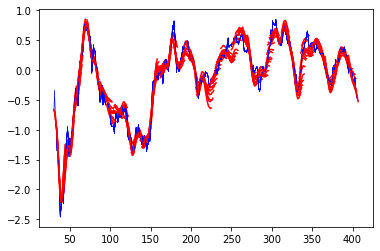

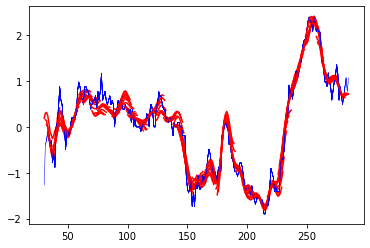

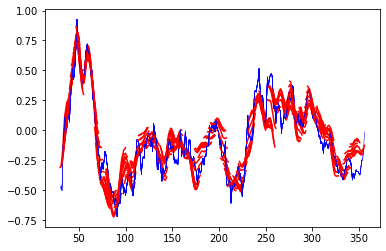

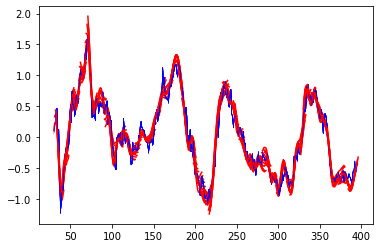

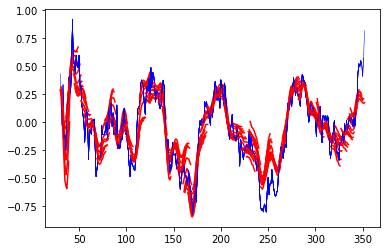

In [54]:
for i, p in enumerate(pred):
    for j, y in enumerate(p):
        
    #print(p.shape)
        plt.plot(range(30+j,40+j), datayes[i][j], c='blue', linewidth=.5)
        plt.plot(range(30+j,40+j), y, c='red')
    plt.show()

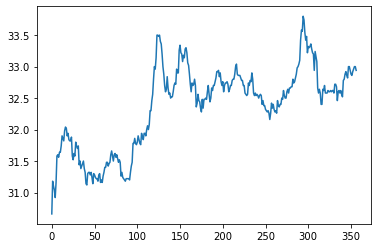

In [39]:
plt.plot(data[0]['open'])

## Save model

In [35]:
# Save model

model.save('models/rnn_model.h5')

In [56]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0223-158D

 Directory of C:\Users\Stian\Documents\School\99. Div\intradag

19.09.2020  00.30    <DIR>          .
19.09.2020  00.30    <DIR>          ..
16.08.2020  17.38    <DIR>          .idea
01.09.2020  19.48    <DIR>          .ipynb_checkpoints
24.08.2020  21.27    <DIR>          data
26.08.2020  22.16    <DIR>          history
18.09.2020  19.30    <DIR>          images
25.08.2020  13.08    <DIR>          lib
30.08.2020  10.25           514ÿ958 make_model.ipynb
19.09.2020  00.30    <DIR>          models
29.08.2020  11.29               664 README.md
19.09.2020  00.29           132ÿ506 RNN_trial.ipynb
16.08.2020  17.14         3ÿ922ÿ732 smadaytrade.ipynb
01.09.2020  20.07           775ÿ971 use_model.ipynb
17.08.2020  12.53    <DIR>          __pycache__
               5 File(s)      5ÿ346ÿ831 bytes
              10 Dir(s)  75ÿ003ÿ355ÿ136 bytes free
